# San Diego Burrito Analytics: Data characterization

Scott Cole

21 May 2016

This notebook characterizes the collection of reviewers of San Diego burritos including:

1. Metadata
2. How many of each kind of burrito have been reviewed?
3. For each of burrito dimension, what is the distribution of its scores across all samples?

### Default imports

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_style("white")

### Load data

In [2]:
import util
df = util.load_burritos()
N = df.shape[0]

### Brief metadata

In [3]:
print 'Number of burritos:', df.shape[0]
print 'Number of restaurants:', len(df.Location.unique())
print 'Number of reviewers:', len(df.Reviewer.unique())
print 'Number of reviews by Scott:', df.Reviewer.value_counts()['Scott']
print 'Number of reviews by Emily:', df.Reviewer.value_counts()['Emily']

uniqlocidx = df.Location.drop_duplicates().index
print 'Percentage of taco shops with free chips:', np.round(100 - 100*df.Chips[uniqlocidx].isnull().sum()/np.float(len(df.Location.unique())),1)

Number of burritos: 204
Number of restaurants: 51
Number of reviewers: 52
Number of reviews by Scott: 69
Number of reviews by Emily: 35
Percentage of taco shops with free chips: 27.5


### What types of burritos have been rated?

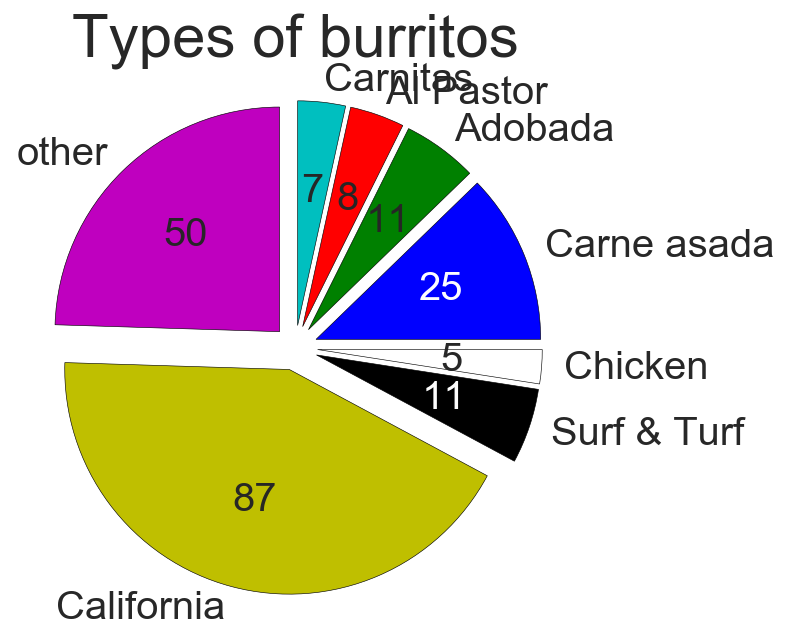

In [4]:
# Number of each type of burrito
def burritotypes(x, types = {'California':'cali', 'Carnitas':'carnita', 'Carne asada':'carne asada',
                             'Chicken':'chicken', 'Surf & Turf':'surf.*turf', 'Adobada':'adobad', 'Al Pastor':'pastor'}):
    import re
    T = len(types)
    Nmatches = {}
    for b in x:
        matched = False
        for t in types.keys():
            re4str = re.compile('.*'+types[t]+'.*', re.IGNORECASE)
            if np.logical_and(re4str.match(b) is not None, matched is False):
                try:
                    Nmatches[t] +=1
                except KeyError:
                    Nmatches[t] = 1
                matched = True
        if matched is False:
            try:
                Nmatches['other'] +=1
            except KeyError:
                Nmatches['other'] = 1
    return Nmatches

typecounts = burritotypes(df.Burrito)

plt.figure(figsize=(6,6))
ax = plt.axes([0.1, 0.1, 0.65, 0.65])

# The slices will be ordered and plotted counter-clockwise.
labels = typecounts.keys()
fracs = typecounts.values()
explode=[.1]*len(typecounts)

patches, texts, autotexts = plt.pie(fracs, explode=explode, labels=labels,
                autopct=lambda(p): '{:.0f}'.format(p * np.sum(fracs) / 100), shadow=False, startangle=0)
                # The default startangle is 0, which would start
                # the Frogs slice on the x-axis.  With startangle=90,
                # everything is rotated counter-clockwise by 90 degrees,
                # so the plotting starts on the positive y-axis.

plt.title('Types of burritos',size=30)
for t in texts:
    t.set_size(20)
for t in autotexts:
    t.set_size(20)
autotexts[0].set_color('w')
autotexts[6].set_color('w')

figname = 'burritotypes'
plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

### Progress in number of burritos rated

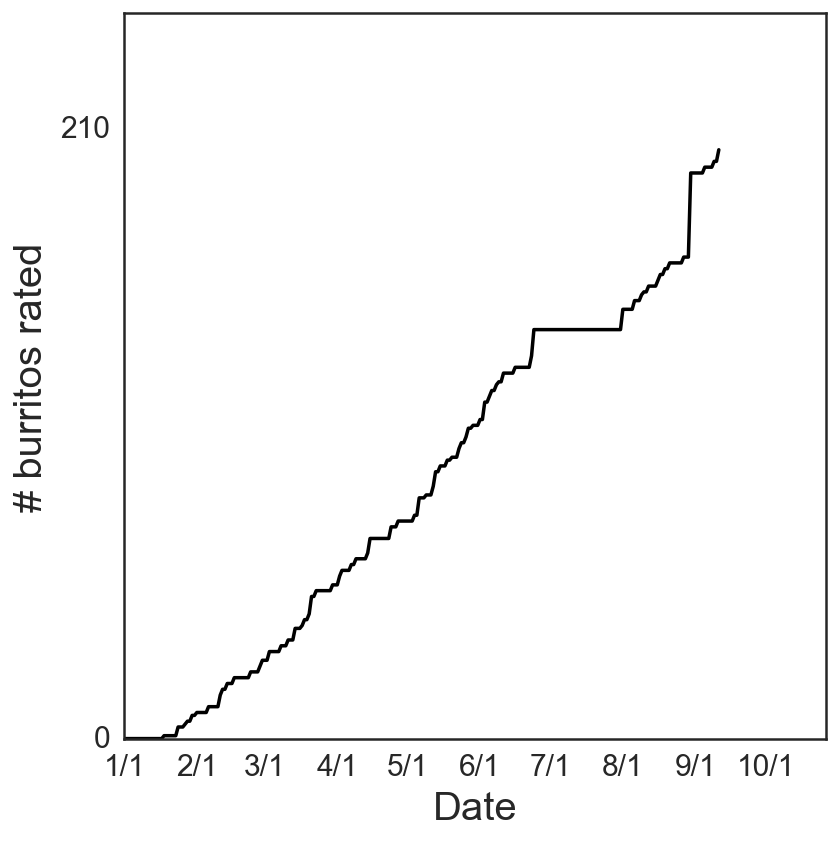

In [13]:
# Time series of ratings
import math

def dates2ts(dates):
    from datetime import datetime
    
    D = len(dates)
    start = datetime.strptime('1/1/2016','%m/%d/%Y')
    ts = np.zeros(D,dtype=int)
    for d in range(D):
        burrdate = datetime.strptime(df.Date[d],'%m/%d/%Y')
        diff = burrdate - start
        ts[d] = diff.days
    return ts

def cumburritos(days):
    from statsmodels.distributions.empirical_distribution import ECDF
    ecdf = ECDF(days)
    t = np.arange(days[-1]+1)
    return t, ecdf(t)*len(days)

def datelabels(startdate = '1/1/2016', M = 10):
    from datetime import datetime
    start = datetime.strptime(startdate,'%m/%d/%Y')
    datestrs = []
    ts = np.zeros(M)
    for m in range(M):
        datestrs.append(str(m+1) + '/1')
        burrdate = datetime.strptime(datestrs[m]+'/2016','%m/%d/%Y')
        diff = burrdate - start
        ts[m] = diff.days
    return datestrs, ts

burrdays = dates2ts(df.Date)
t, burrcdf = cumburritos(burrdays)
datestrs, datets = datelabels()

plt.figure(figsize=(6,6))
plt.plot(t,burrcdf,'k-')
plt.xlabel('Date',size=20)
plt.ylabel('# burritos rated',size=20)
plt.xticks(datets,datestrs,size=15)
plt.yticks((0,int(math.ceil(len(burrdays) / 10.0)) * 10),size=15)
plt.tight_layout()

figname = 'burritoprogress'
plt.savefig('C:/Users/Scott/Google Drive/qwm/burritos/figs/'+figname + '.png')

# Burrito dimension distributions

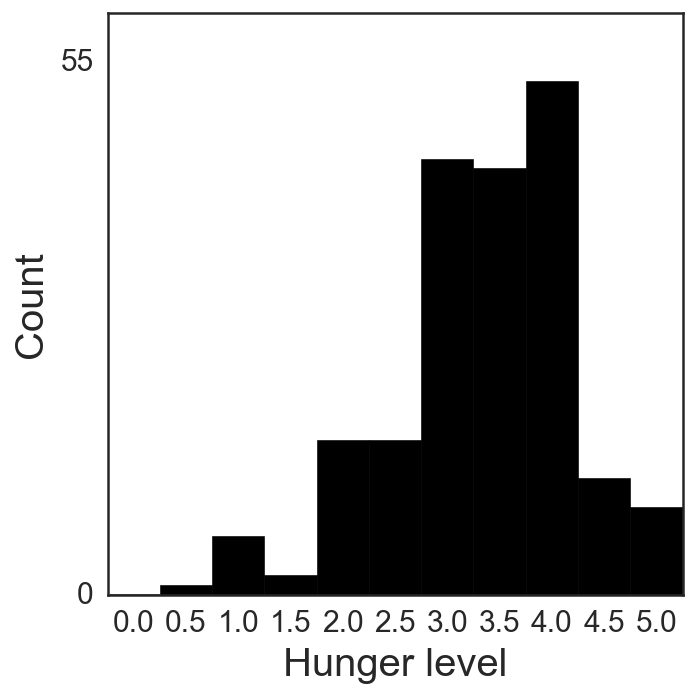

In [6]:
# Distribution of hunger level
plt.figure(figsize=(5,5))
n, _, _ = plt.hist(df.Hunger,np.arange(-.25,5.5,.5),color='k')
plt.xlabel('Hunger level',size=20)
plt.xticks(np.arange(0,5.5,.5),size=15)
plt.xlim((-.25,5.25))
plt.ylabel('Count',size=20)
plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=15)
plt.tight_layout()

figname = 'hungerleveldist'
plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

6.89799019608


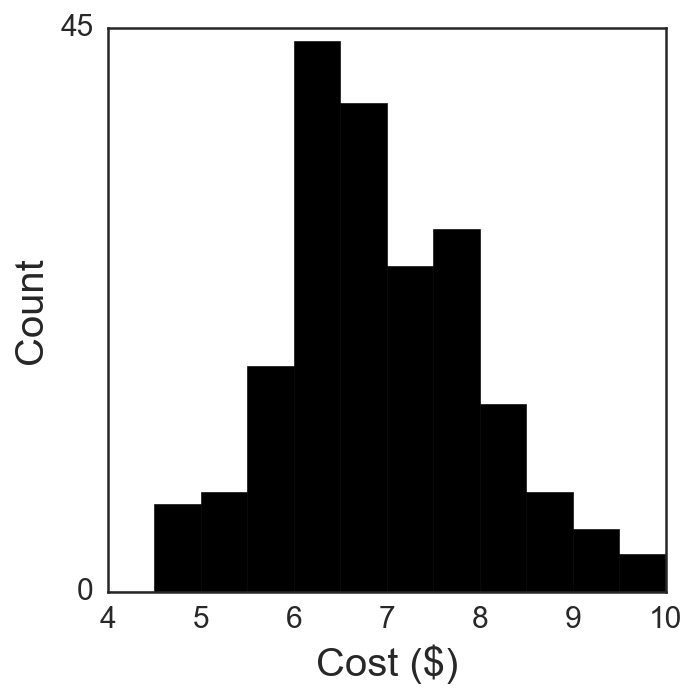

In [7]:
# Average burrito cost
plt.figure(figsize=(5,5))
n, _, _ = plt.hist(df.Cost,np.arange(4,10.25,.5),color='k')
plt.xlabel('Cost ($)',size=20)
plt.xticks(np.arange(4,11,1),size=15)
plt.xlim((4,10))
plt.ylabel('Count',size=20)
plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=15)
plt.tight_layout()

figname = 'costdist'
plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

print np.mean(df.Cost)

0.784035087719


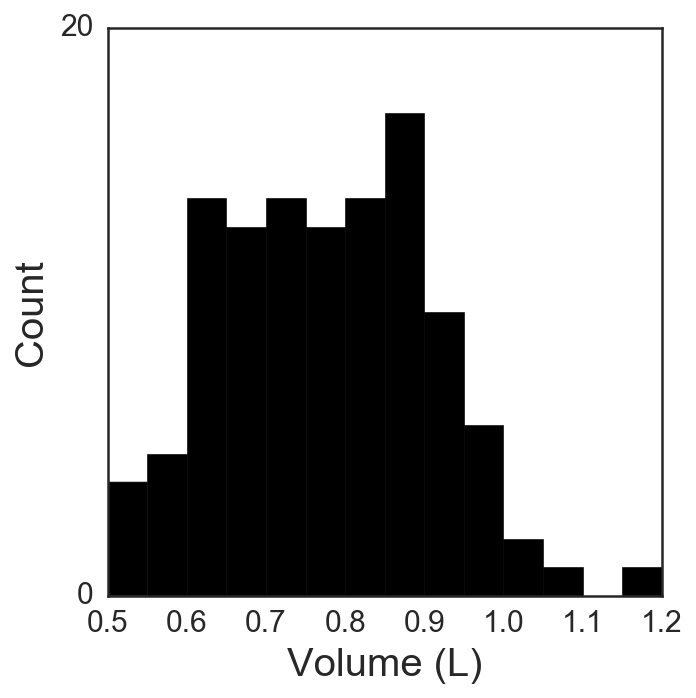

In [8]:
# Volume dist
plt.figure(figsize=(5,5))
n, _, _ = plt.hist(df.Volume.dropna(),np.arange(0.5,1.3,.05),color='k')
plt.xlabel('Volume (L)',size=20)
plt.xticks(np.arange(0.5,1.3,.1),size=15)
plt.xlim((0.5,1.2))
plt.ylabel('Count',size=20)
plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=15)
plt.tight_layout()

figname = 'volumedist'
plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

print np.mean(df.Volume)

In [9]:
def metrichist(metricname):
    plt.figure(figsize=(5,5))
    n, _, _ = plt.hist(df[metricname].dropna(),np.arange(-.25,5.5,.5),color='k')
    plt.xlabel(metricname + ' rating',size=20)
    plt.xticks(np.arange(0,5.5,.5),size=15)
    plt.xlim((-.25,5.25))
    plt.ylabel('Count',size=20)
    plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=15)
    plt.tight_layout()
    
    if metricname == 'Meat:filling':
        metricname = 'meattofilling'
    figname = metricname + 'dist'
    plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

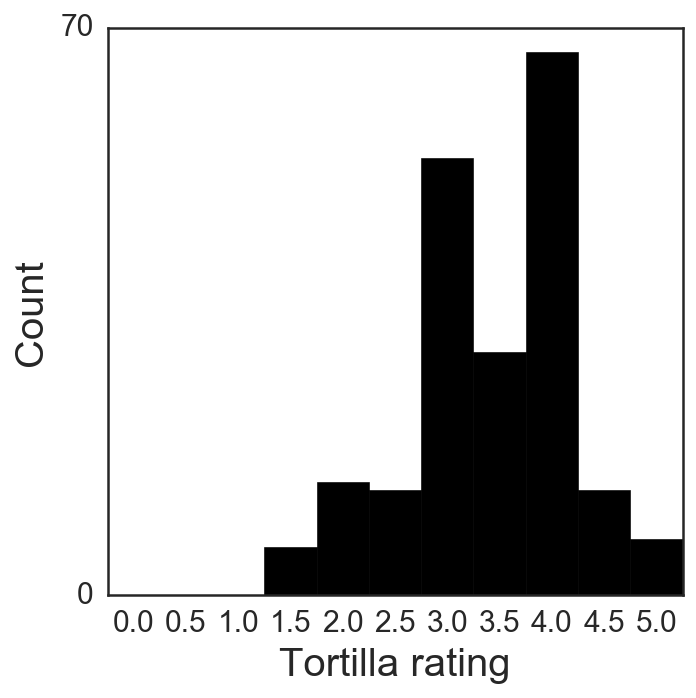

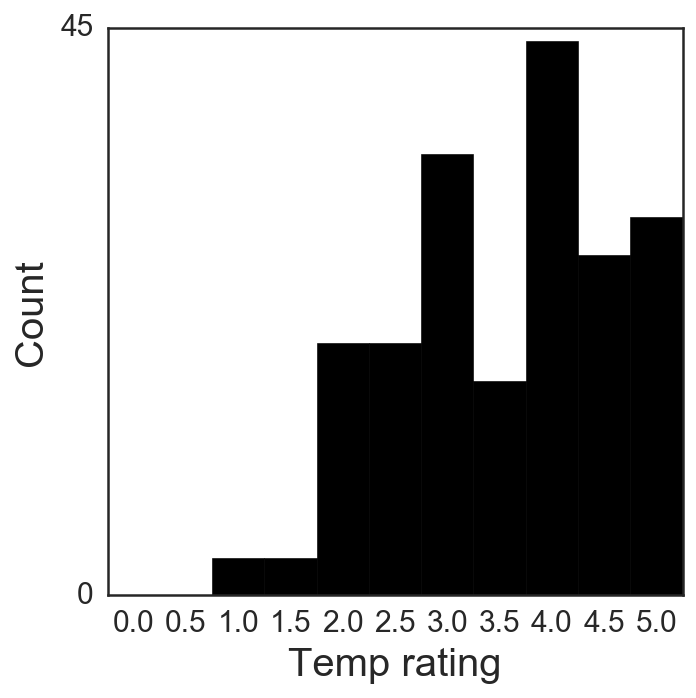

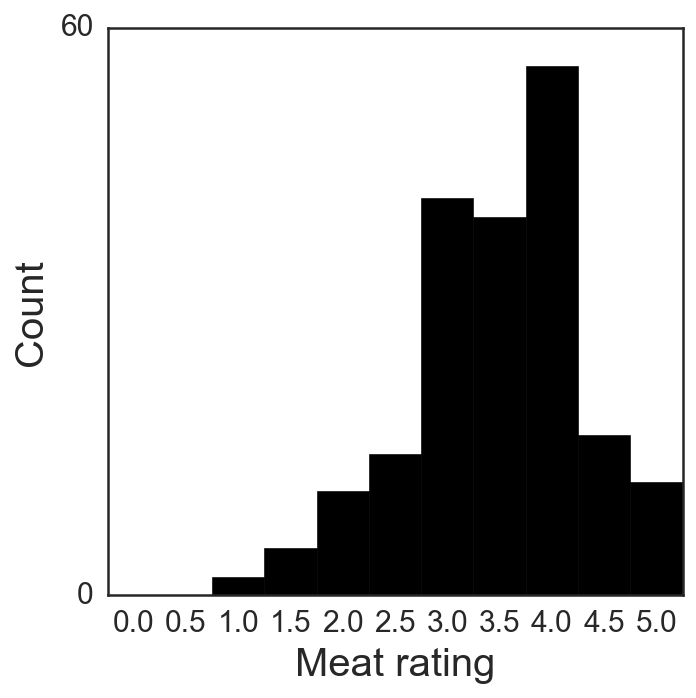

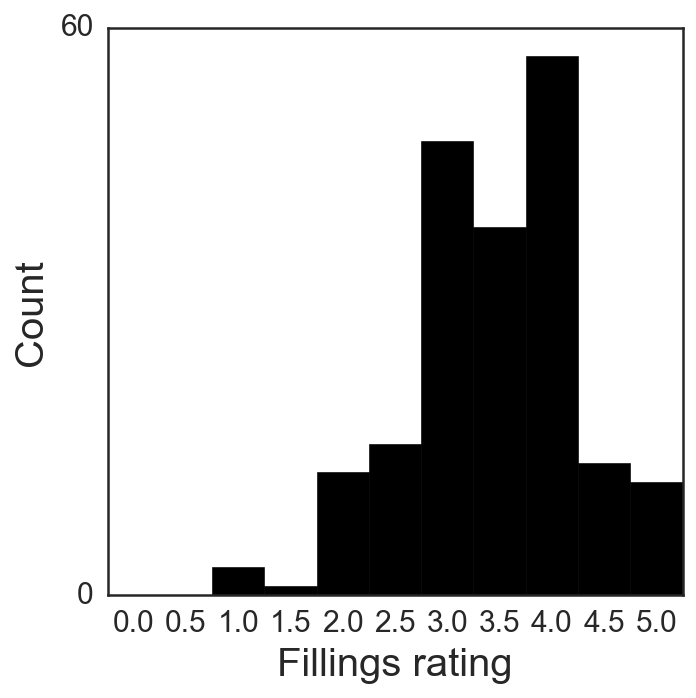

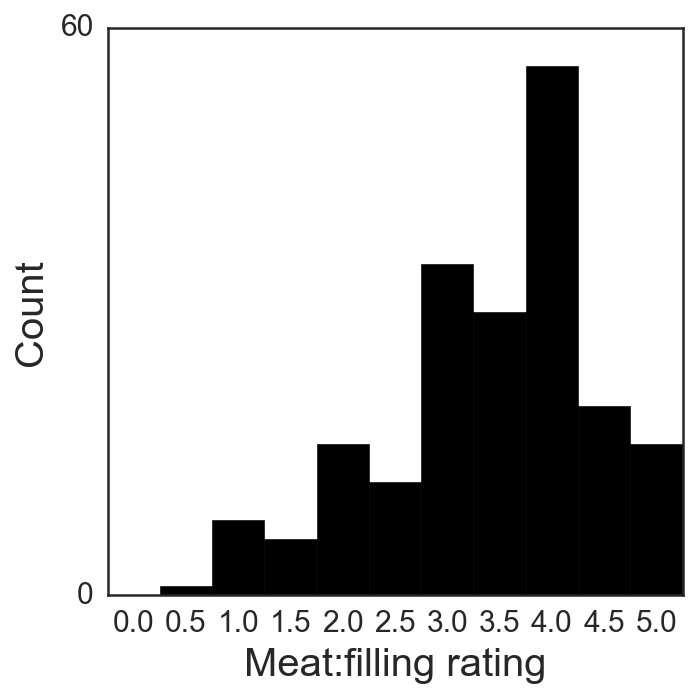

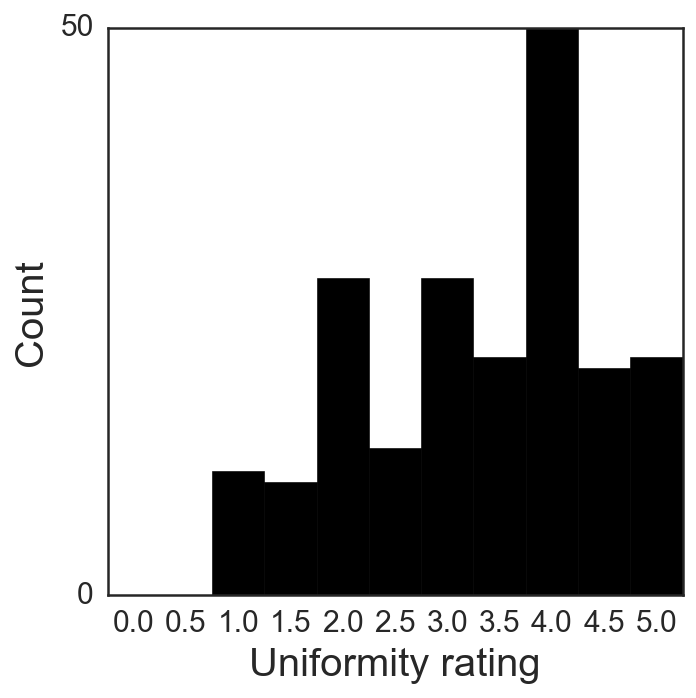

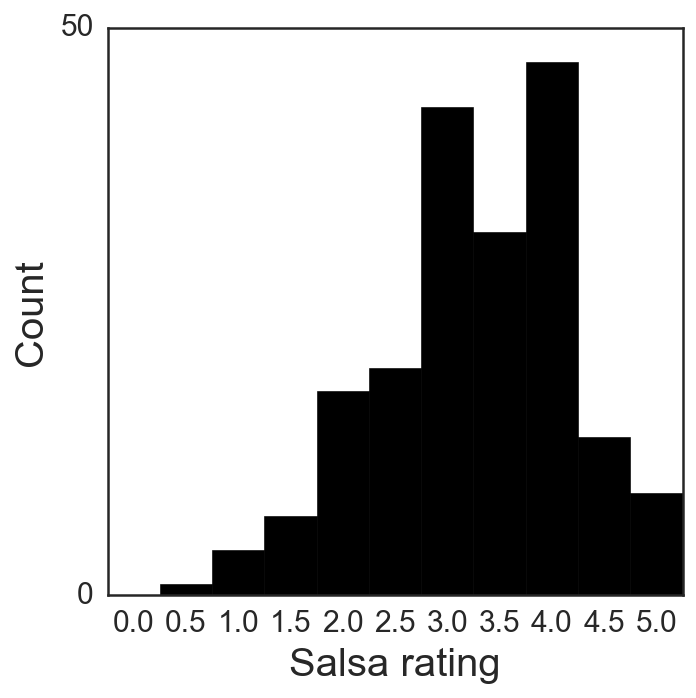

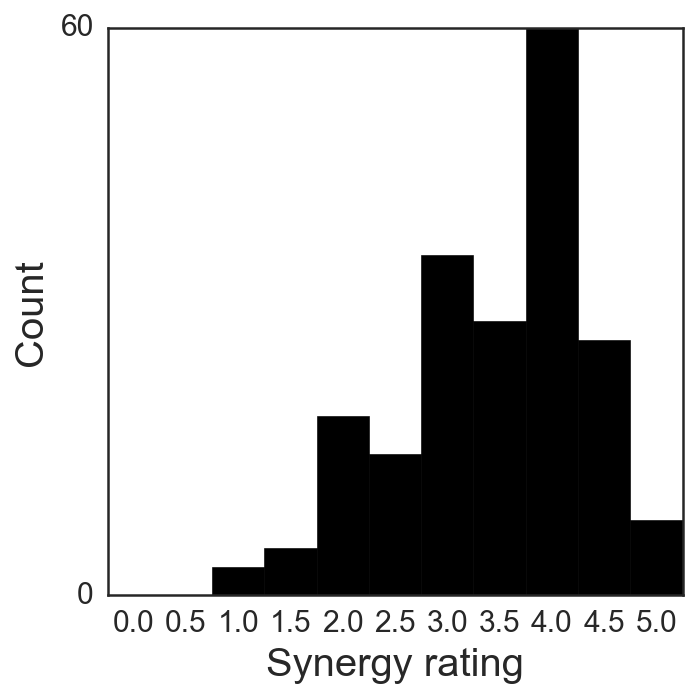

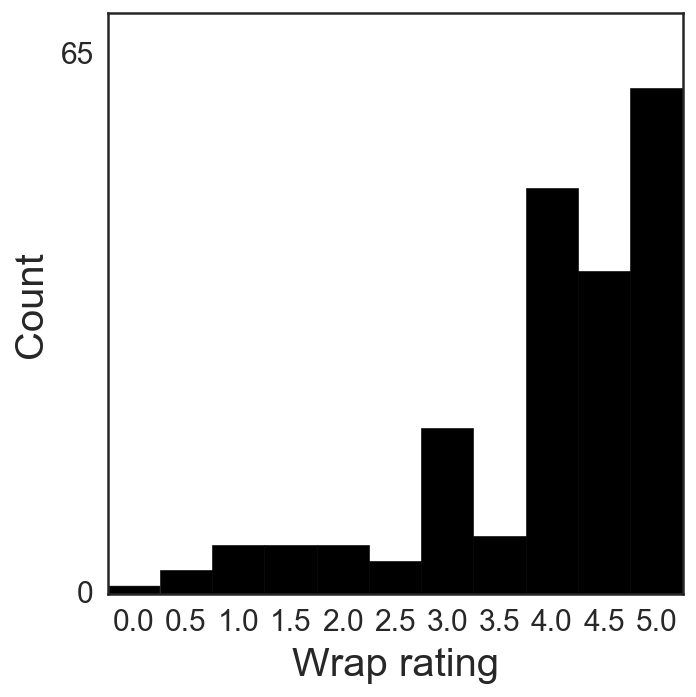

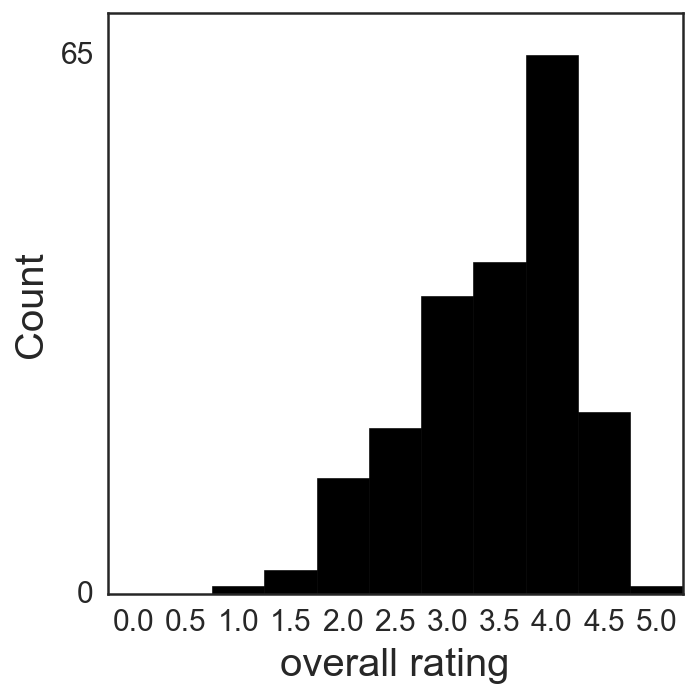

In [10]:
m_Hist = ['Tortilla','Temp','Meat','Fillings','Meat:filling','Uniformity','Salsa','Synergy','Wrap','overall']
for m in m_Hist:
    metrichist(m)

# Fraction of burritos recommended

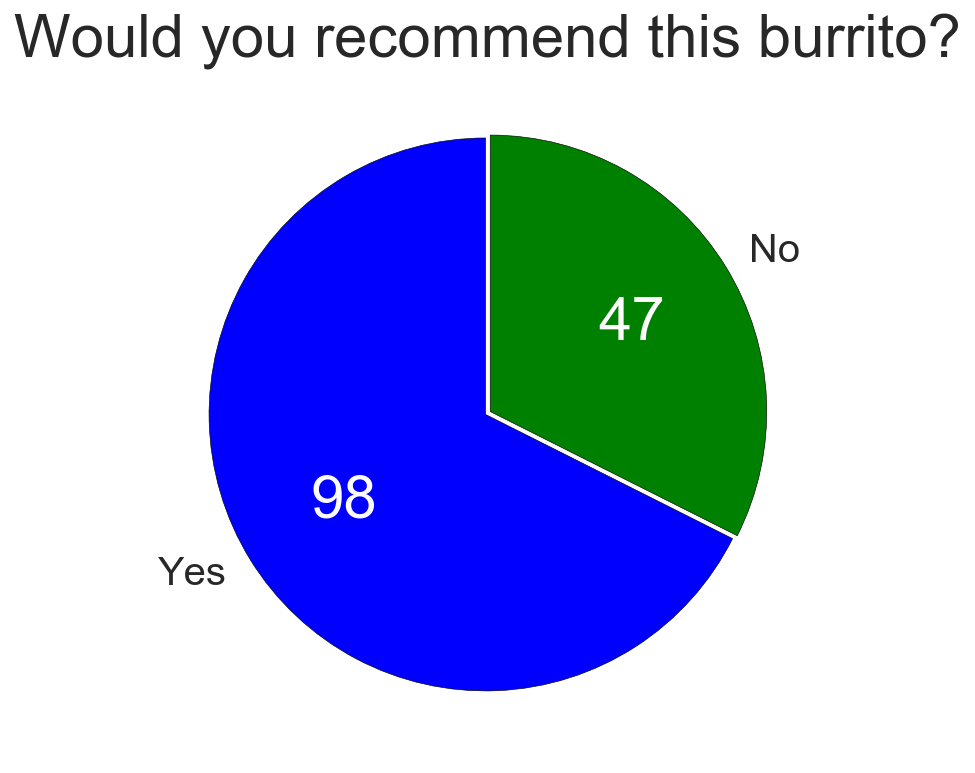

In [11]:
# Overall recommendations
plt.figure(figsize=(6,6))
ax = plt.axes([0.1, 0.1, 0.8, 0.8])

# The slices will be ordered and plotted counter-clockwise.
labels = ['Yes','No']
fracs = np.array([np.sum(df.Rec==labels[0]),np.sum(df.Rec==labels[1])])
explode=[.01]*len(labels)

patches, texts, autotexts = plt.pie(fracs, explode=explode, labels=labels,
                autopct=lambda(p): '{:.0f}'.format(p * np.sum(fracs) / 100), shadow=False, startangle=90)
                # The default startangle is 0, which would start
                # the Frogs slice on the x-axis.  With startangle=90,
                # everything is rotated counter-clockwise by 90 degrees,
                # so the plotting starts on the positive y-axis.

plt.title('Would you recommend this burrito?',size=30)
for t in texts:
    t.set_size(20)
for t in autotexts:
    t.set_size(30)
autotexts[0].set_color('w')
autotexts[1].set_color('w')

figname = 'recspie'
plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

# PCA

In [16]:
dfpca = df[['Volume','Tortilla','Temp','Meat','Fillings','Meat:filling','Uniformity','Salsa','Synergy','Wrap']]

In [21]:
dfpca = dfpca.fillna(dfpca.mean())

In [30]:
# Normalize
dfpca = (dfpca - dfpca.mean()) / dfpca.std()
dfpca

,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap
0,-9.195760e-15,-0.531071,1.409599e+00,-0.570042,0.054413,0.576688,6.114679e-01,8.026590e-01,0.614032,0.036957
1,-9.195760e-15,-1.803396,-6.366884e-02,-1.170718,-1.166120,-1.400809,6.114679e-01,2.542410e-01,-1.053097,0.905026
2,-9.195760e-15,-0.531071,-1.536936e+00,-1.170718,-0.555853,1.071062,6.114679e-01,-2.941771e-01,-0.497388,0.905026
3,-9.195760e-15,-0.531071,-1.536936e+00,0.030634,-0.555853,0.576688,1.489964e+00,8.026590e-01,0.614032,0.905026
4,-9.195760e-15,0.741254,1.409599e+00,0.631311,0.054413,1.071062,1.489964e+00,-8.425951e-01,1.169742,0.036957
5,-9.195760e-15,-0.531071,4.274203e-01,1.832663,0.054413,-0.906435,-7.062759e-01,-8.425951e-01,0.614032,-2.567249
6,-9.195760e-15,-1.803396,-5.547580e-01,-0.570042,-1.776386,-0.906435,-7.062759e-01,-4.870931e-16,-1.608807,-0.831111
7,-9.195760e-15,-1.167233,-5.547580e-01,-0.570042,-1.166120,-0.412061,1.722200e-01,-4.870931e-16,-1.053097,-0.831111
8,-9.195760e-15,-1.803396,9.185094e-01,1.231987,0.054413,-1.895184,-2.670280e-01,2.542410e-01,0.614032,-1.699180
9,-9.195760e-15,-1.167233,-2.028025e+00,-2.372071,-0.555853,1.071062,-2.670280e-01,-1.939431e+00,-1.608807,0.470992


In [31]:
# Color: Taco Stand, Lucha, Los Primos

In [85]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(dfpca)
print pca.components_
print pca.explained_variance_ratio_

[[ 0.09765744  0.34841303  0.17617929  0.38729375  0.40900649  0.34360716
   0.30114858  0.29474487  0.45413472  0.13740543]
 [ 0.50281001 -0.02748591 -0.42664265  0.21786445  0.26934336 -0.31935538
  -0.30297005  0.13144003  0.14659128 -0.46026917]]
[ 0.32163069  0.12433452]


In [81]:
np.sum(pca.components_,1)

array([ 2.94959077, -0.26867402, -0.47266596,  0.65473686, -0.45869249,
        0.34878559, -0.48397107, -0.08103247, -0.04151549,  0.03266678])

In [88]:
dfpca_proj = np.dot(pca.components_,dfpca.T)

In [96]:
np.sum(df.Location=='taco stand')

19

In [155]:
foo = 'abc'
bar = 'ba'
zoo = '123'
foo == 'abc' and bar == 'bac' or zoo == '123'

True

In [100]:
dfpca_proj[0][np.where(df.Location=='taco stand')]

array([ 0.88590208,  2.05719359,  1.46041676,  1.05243836,  2.08841004,
        0.65603141,  1.008253  ,  0.80513815,  3.84705556,  1.17511301,
        2.86302247,  0.47339651,  1.15584287,  2.32742707,  0.77233354,
        1.12035477,  0.3661295 ,  1.06226665,  0.82618765])

In [160]:
shops[0] is 

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [172]:
np.sum(np.logical_or(notshops,df.Location==shops[2]))

157

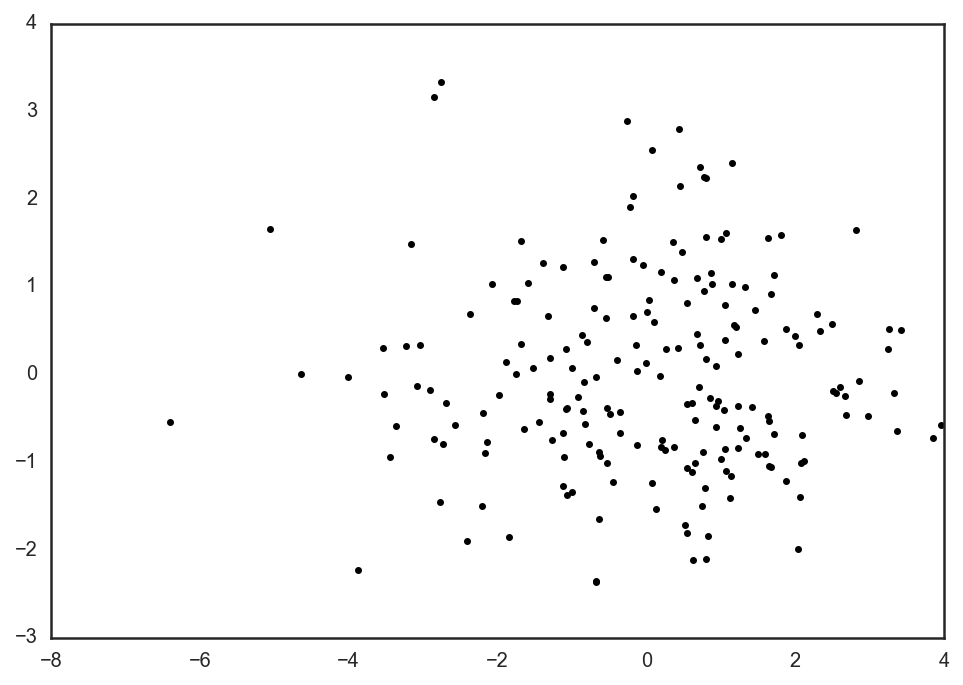

In [173]:
plt.plot(dfpca_proj[0],dfpca_proj[1],'k.')

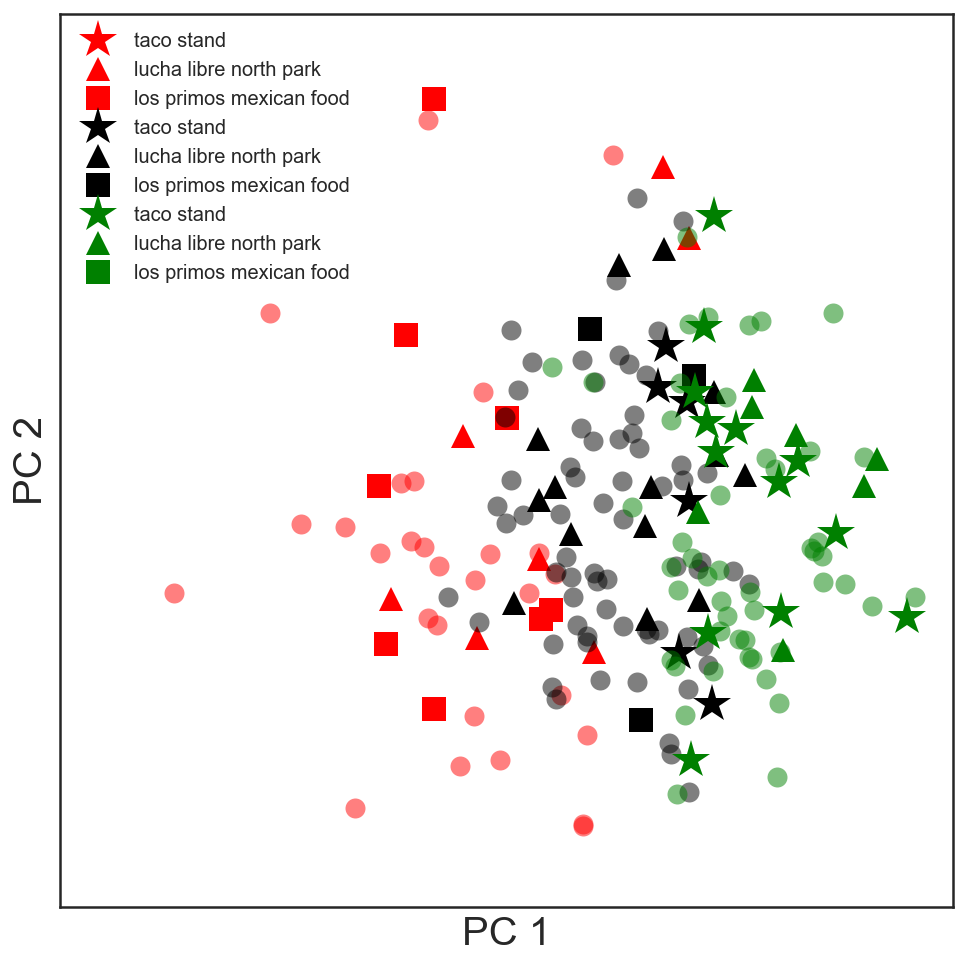

In [213]:
plt.figure(figsize=(8,8))
shops = ['taco stand','lucha libre north park','los primos mexican food']
shops_marker = ['*','^','s']
shops_ms = [20,12,12]
overallcutoffs = [-.1, 3, 4, 5.1]
overallcolors = ['r','k','g']


for o in range(len(overallcolors)):
    notshops = np.logical_and(df.Location != shops[0],np.logical_and(df.Location != shops[1],df.Location != shops[2]))
    orange = np.logical_and(df.overall>=overallcutoffs[o],df.overall<overallcutoffs[o+1])
    notshops = np.where(np.logical_and(notshops,orange))
    plt.plot(dfpca_proj[0][notshops],dfpca_proj[1][notshops],'.',color=overallcolors[o],alpha=.5,ms=20)
    for s in range(len(shops)):
        burridx = np.where(np.logical_and(df.Location==shops[s],np.logical_and(df.overall>=overallcutoffs[o],df.overall<overallcutoffs[o+1])))
        plt.plot(dfpca_proj[0][burridx],dfpca_proj[1][burridx],
                 shops_marker[s],color=overallcolors[o],ms=shops_ms[s],label = shops[s])
plt.xlim((-8,4.5))
plt.ylim((-3,4))
plt.xlabel('PC 1',size=20)
plt.ylabel('PC 2',size=20)
plt.xticks([])
plt.yticks([])
plt.legend(loc='best')

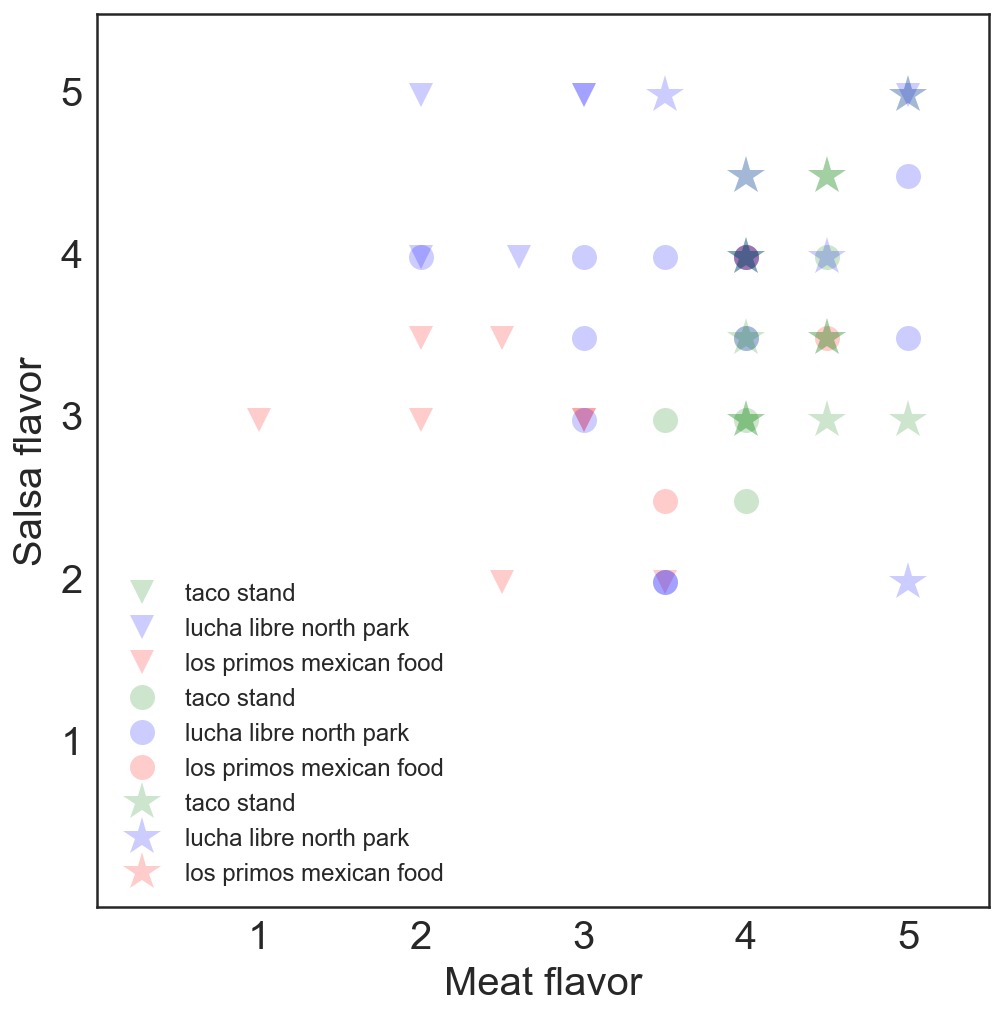

In [233]:
shopsalpha = [.2,.2,.2]
shops = ['taco stand','lucha libre north park','los primos mexican food']
overall_marker = ['v','.','*']
overall_ms = [12,25,20]
overallcutoffs = [-.1, 3, 4, 5.1]
shopscolors = ['g','b','r']

plt.figure(figsize=(8,8))
for o in range(len(overallcolors)):
    notshops = np.logical_and(df.Location != shops[0],np.logical_and(df.Location != shops[1],df.Location != shops[2]))
    orange = np.logical_and(df.overall>=overallcutoffs[o],df.overall<overallcutoffs[o+1])
    notshops = np.where(np.logical_and(notshops,orange))[0]
    #plt.plot(df.Meat[notshops],df.Fillings[notshops],'.',color=overallcolors[o],alpha=.2,ms=20)
    for s in range(len(shops)):
        burridx = np.where(np.logical_and(df.Location==shops[s],np.logical_and(df.overall>=overallcutoffs[o],df.overall<overallcutoffs[o+1])))[0]
        plt.plot(df.Meat[burridx],df.Salsa[burridx],
                 overall_marker[o],color=shopscolors[s],ms=overall_ms[o],alpha=shopsalpha[s],label=shops[s])
plt.xlim((0,5.5))
plt.ylim((0,5.5))
plt.xlabel('Meat flavor',size=20)
plt.ylabel('Salsa flavor',size=20)
plt.xticks(np.arange(1,6),size=20)
plt.yticks(np.arange(1,6),size=20)
plt.legend(loc='best',fontsize=12)

plt.savefig('C:/gh/fig/burrito/superscatter.png')

In [90]:
np.shape(dfpca_proj)

(2L, 204L)

In [82]:
x_pca = np.dot(pca.components_,x_orig)

In [83]:
print np.dot(pca.components_.T,x_pca)

[ -9.95904748e-15  -5.31070874e-01   1.40959850e+00  -5.70041830e-01
   5.44129113e-02   5.76687551e-01   6.11467935e-01   8.02659032e-01
   6.14031764e-01   3.69573866e-02]


In [71]:
print x_orig

Volume         -9.195760e-15
Tortilla       -5.310709e-01
Temp            1.409599e+00
Meat           -5.700418e-01
Fillings        5.441291e-02
Meat:filling    5.766876e-01
Uniformity      6.114679e-01
Salsa           8.026590e-01
Synergy         6.140318e-01
Wrap            3.695739e-02
Name: 0, dtype: float64


In [73]:
print pca.components_[0]

[ 0.09765744  0.34841303  0.17617929  0.38729375  0.40900649  0.34360716
  0.30114858  0.29474487  0.45413472  0.13740543]


In [56]:
np.sum(pca.components_[0]**2)

1.0000000000000011

In [58]:
pca.components_*pca.components_.T

array([[ 0.00953698,  0.17518556, -0.08395793,  0.0855488 , -0.21218411,
         0.10940187, -0.08237025,  0.02392257, -0.0408322 , -0.00577168],
       [ 0.17518556,  0.00075548, -0.02746482,  0.08013454, -0.10350491,
         0.08706546, -0.1871041 ,  0.02354216,  0.04703314, -0.0011345 ],
       [-0.08395793, -0.02746482,  0.28031395,  0.06962721, -0.09592562,
        -0.02398881,  0.15960475, -0.01438517, -0.01580955,  0.01237789],
       [ 0.0855488 ,  0.08013454,  0.06962721,  0.0319624 ,  0.00287354,
        -0.10198595,  0.08876062, -0.10470086, -0.11025997, -0.02568708],
       [-0.21218411, -0.10350491, -0.09592562,  0.00287354,  0.01921571,
         0.00181884, -0.07408716, -0.10068352, -0.10101703,  0.1781688 ],
       [ 0.10940187,  0.08706546, -0.02398881, -0.10198595,  0.00181884,
         0.02286713,  0.0232675 , -0.35385593,  0.003204  ,  0.17962443],
       [-0.08237025, -0.1871041 ,  0.15960475,  0.08876062, -0.07408716,
         0.0232675 ,  0.0009796 ,  0.25611333

In [48]:
pca.explained_variance_ratio_

array([ 0.32163069,  0.12433452,  0.11093486,  0.09792622,  0.083168  ,
        0.0781746 ,  0.05988365,  0.04859178,  0.04531033,  0.03004535])

In [60]:
x_orig = dfpca.loc[0]
x_orig2 = np.dot(x_orig)

TypeError: Required argument 'b' (pos 2) not found

In [29]:
np.dot(pca.components_[0],

array([-0.00553954, -0.26601036, -0.21152175, -0.30084128, -0.30499351,
       -0.4323321 , -0.46177822, -0.26974524, -0.40640739, -0.25071938])